In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 모델 구현 부분

In [2]:
class resnet(nn.Module):
    def __init__(self):
        #First node
        super(resnet , self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3 , out_channels= 64 , kernel_size= 3 ,  padding= 1 , stride= 1  , bias = True)

        #basic block 1
        self.conv64 = nn.Conv2d(in_channels= 64 , out_channels= 64 , kernel_size= 3 ,  padding= 1 , stride= 1  , bias = True)
        self.bn64_0 = nn.BatchNorm2d(num_features= 64)
        self.bn64_1 = nn.BatchNorm2d(num_features= 64)
        self.bn64_2 = nn.BatchNorm2d(num_features= 64)
        self.bn64_3 = nn.BatchNorm2d(num_features= 64)
        self.bn64_4 = nn.BatchNorm2d(num_features= 64)

        #basic block 2        
        self.conv3 = nn.Conv2d(in_channels= 64 , out_channels= 128 , kernel_size= 3 ,  padding= 1 , stride= 2 , bias = True)
        self.conv128 = nn.Conv2d(in_channels= 128 , out_channels= 128 , kernel_size= 3 ,  padding= 1 , stride= 1  , bias = True)
        self.bn128_1 = nn.BatchNorm2d(num_features= 128)
        self.bn128_2 = nn.BatchNorm2d(num_features= 128)
        self.bn128_3 = nn.BatchNorm2d(num_features= 128)
        self.bn128_4 = nn.BatchNorm2d(num_features= 128)
        self.short_cut16 = nn.Sequential(
                nn.Conv2d(64 , 128 , kernel_size=1 , stride = 2 , bias = True )
                ,nn.BatchNorm2d(128))
        self.short_cut8 = nn.Sequential(
                nn.Conv2d(128 , 256 , kernel_size=1 , stride = 2 , bias = True )
              ,  nn.BatchNorm2d(256))
        self.short_cut4 = nn.Sequential(
                nn.Conv2d(256 , 512 , kernel_size=1 , stride = 2 , bias = True )
              ,  nn.BatchNorm2d(512))
        #basic blcok 3
        self.conv4 = nn.Conv2d(in_channels= 128 , out_channels= 256 , kernel_size= 3 ,  padding= 1 , stride= 2 , bias = True )
        self.conv256 = nn.Conv2d(in_channels= 256 , out_channels= 256 , kernel_size= 3 ,  padding= 1 , stride= 1  , bias = True)
        self.bn256_1 = nn.BatchNorm2d(num_features= 256)
        self.bn256_2 = nn.BatchNorm2d(num_features= 256)
        self.bn256_3 = nn.BatchNorm2d(num_features= 256)
        self.bn256_4 = nn.BatchNorm2d(num_features= 256)

        #basic blcok 4
        self.conv5 = nn.Conv2d(in_channels= 256 , out_channels= 512 , kernel_size= 3 ,  padding= 1 , stride= 2 , bias = True )
        self.conv512 = nn.Conv2d(in_channels= 512 , out_channels= 512 , kernel_size= 3 ,  padding= 1 , stride= 1 , bias = True )
        self.bn512_1 = nn.BatchNorm2d(num_features= 512)
        self.bn512_2 = nn.BatchNorm2d(num_features= 512)
        self.bn512_3 = nn.BatchNorm2d(num_features= 512)
        self.bn512_4 = nn.BatchNorm2d(num_features= 512)
        self.linear = nn.Linear(1 * 1 * 512 ,out_features= 10 , bias = True )
        
    def forward(self , x):
        #first layer
        out = self.bn64_0(self.conv1(x))
        short_cut = out
        #basic blcok 1
        out = F.relu(self.bn64_1(self.conv64(out)))
        out = F.relu(self.bn64_2(self.conv64(out)))
        out += short_cut
        short_cut = out
        out = F.relu(self.bn64_3(self.conv64(out)))
        out = F.relu(self.bn64_4(self.conv64(out)))
        out += short_cut
        short_cut = self.short_cut16(out)
        #basic block 2
        out = F.relu(self.bn128_1(self.conv3(out)))
        out = F.relu(self.bn128_2(self.conv128(out)))
        # 16 * 16
        out += short_cut
        short_cut = out
        out = F.relu(self.bn128_3(self.conv128(out)))
        out = F.relu(self.bn128_4(self.conv128(out)))
        out += short_cut
        short_cut = self.short_cut8(out)
        #basic block 3
        out = F.relu(self.bn256_1(self.conv4(out)))
        out = F.relu(self.bn256_2(self.conv256(out)))
        out += short_cut
        short_cut = out
        out = F.relu(self.bn256_3(self.conv256(out)))
        out = F.relu(self.bn256_4(self.conv256(out)))
        out += short_cut
        short_cut = self.short_cut4(out)
        #basic block 4
        out = F.relu(self.bn512_1(self.conv5(out)))
        out = F.relu(self.bn512_2(self.conv512(out)))
        out += short_cut
        short_cut = out
        out = F.relu(self.bn512_3(self.conv512(out)))
        out = F.relu(self.bn512_4(self.conv512(out)))
        out += short_cut
        out = F.avg_pool2d(out ,4)
        out = out.view(out.size(0) , -1)
        out = self.linear(out)
        return out

## DataSet Load

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
images , targets = next(iter(test_loader))

images.shape , targets.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [5]:
label = [ 'airplane', 'automobile', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

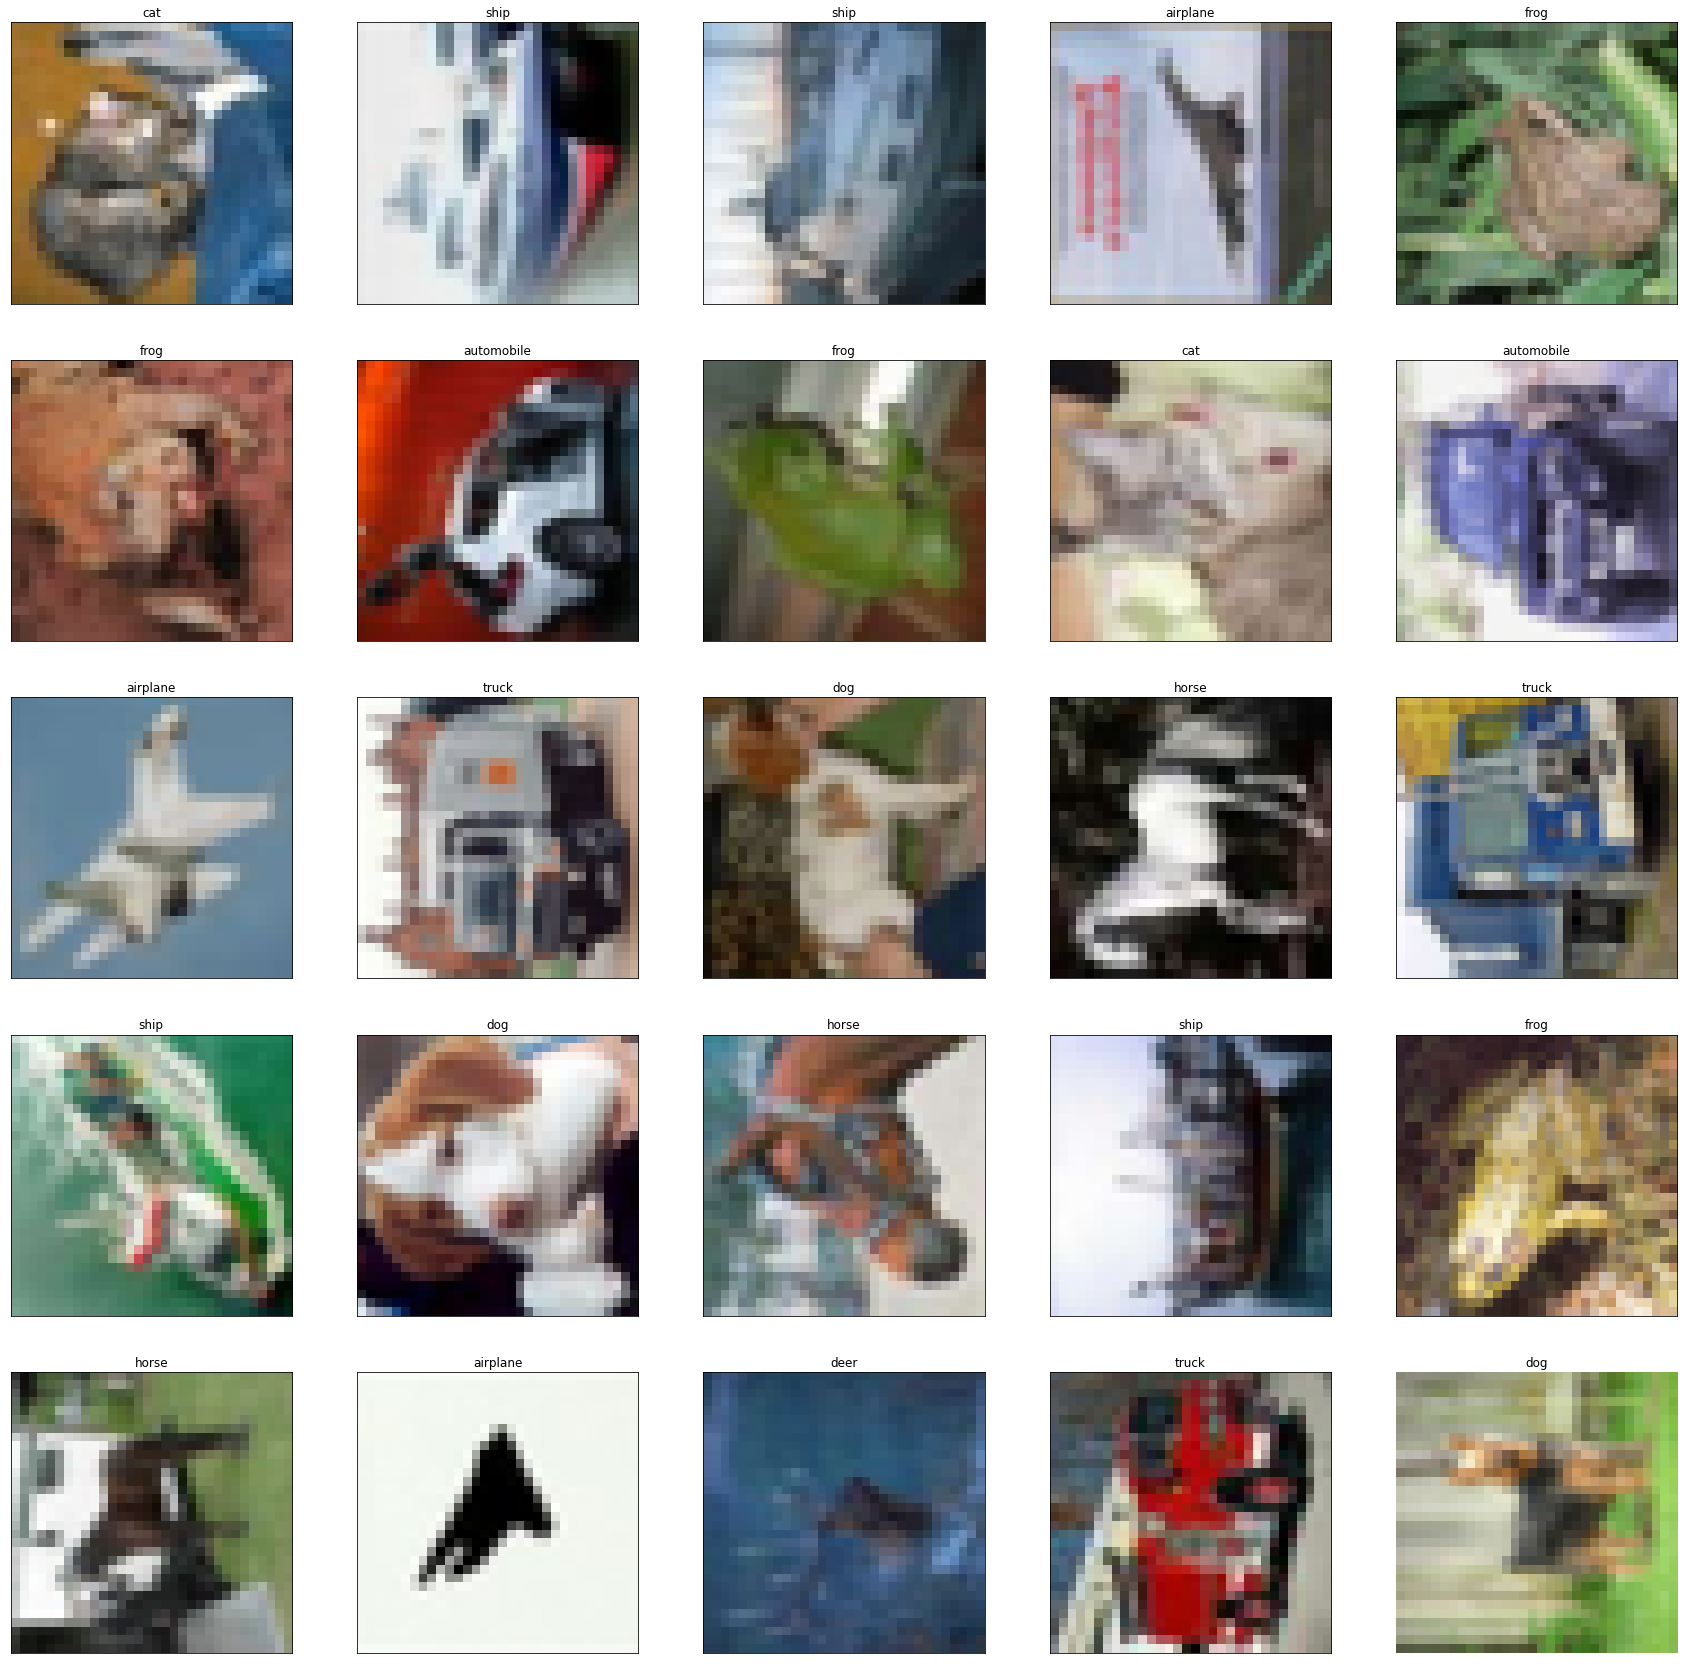

In [6]:
_ , ax  = plt.subplots(5 , 5 , figsize = ( 30 ,30))
k = 0 
for i in range(5):
    for j in range(5):
        ax[i , j].imshow(images[k].permute(2 , 1 , 0).cpu())
        ax[i , j].set_title(label[targets[k].numpy()])
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])
        plt.axis("off")
        k += 1

In [7]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [8]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [9]:
device = 'cuda'
net = resnet()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

In [10]:
summary(net , (3 , 32 ,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11          [-1, 128, 16, 16]           8,320
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

## gpu 확인

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
device

device(type='cuda')

## hyperparameter지정

In [12]:
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## 학습 및 검증 구간

In [13]:
train_loss_list =  []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
train_loss = 0 
correct = 0
total = 0
epochs = 50
net.train()
for epoch in range(epochs):
    #train
    net.train()
    train_loss = 0 
    correct = 0
    total = 0
    for batch_idx  , (inputs , targets) in enumerate(train_loader):
        inputs , targets = inputs.to(device) , targets.to(device)
        optimizer.zero_grad()
        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _ , predicted  = benign_outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print('epoch num :'  , epoch)
    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss everage:', train_loss / total)    
    train_loss_list.append(train_loss / total)
    train_accuracy_list.append(correct / total)
    with torch.no_grad():
        net.eval()
        test_loss = 0
        correct = 0
        total = 0            
        for batch_idx , (inputs , targets) in enumerate(test_loader):
            inputs , targets = inputs.to(device) , targets.to(device)
            total += targets.size(0)
            outputs = net(inputs)
            _ , predicted = outputs.max(1)
            test_loss += criterion(outputs,  targets).item()
            correct += predicted.eq(targets).sum().item()
            
        print('\nTest accuarcy:', 100. * correct / total)
        print('Test average loss:', test_loss / total)
        test_loss_list.append(test_loss / total)
        test_accuracy_list.append(correct / total)

epoch num : 0

Total benign train accuarcy: 27.724
Total benign train loss everage: 0.018629085536003114

Test accuarcy: 38.84
Test average loss: 0.016352980601787567
epoch num : 1

Total benign train accuarcy: 43.078
Total benign train loss everage: 0.012041713197231293

Test accuarcy: 49.27
Test average loss: 0.014341611325740813
epoch num : 2

Total benign train accuarcy: 56.012
Total benign train loss everage: 0.009561797615289688

Test accuarcy: 60.91
Test average loss: 0.011234921836853028
epoch num : 3

Total benign train accuarcy: 64.874
Total benign train loss everage: 0.007801585313081742


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_18020/992800342.py", line 37, in <module>
    for batch_idx , (inputs , targets) in enumerate(test_loader):
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 352, in __iter__
    return self._get_iterator()
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 294, in _get_iterator
    return _MultiProcessingDataLoaderIter(self)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 801, in __init__
    w.start()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\process.py", line 121, in start
    self._popen = self._Popen(self)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\context.py", line 224,

TypeError: object of type 'NoneType' has no len()

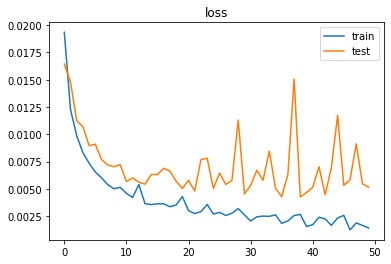

In [22]:
plt.title('loss')
plt.plot(train_loss_list , label  = 'train')
plt.plot(test_loss_list , label = 'test')

plt.legend()
plt.show()

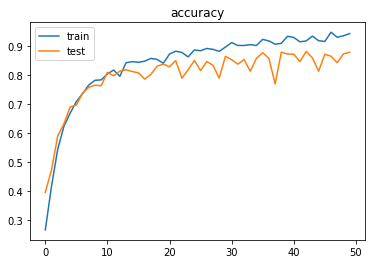

In [21]:
plt.title('accuracy')

plt.plot(train_accuracy_list , label = 'train')
plt.plot(test_accuracy_list , label = 'test')
plt.legend()
plt.show()
